<a href="https://colab.research.google.com/github/Stephl99/coremotion_marketing_analysis/blob/master/Coremotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical Test - Advanced Analytics Team - GroupM Colombia

## 1. Business Context

The country of Macondo is a prosperous place for business. Over time, it has experienced significant economic growth, driven by favorable conditions for industry development. Likewise, population growth has supported the increasing demand for labor and consumer markets.

**CoreMotion**, a leading sports equipment company, has been investing consistently in its marketing mix for several years. Now, the company seeks to take its analytics to the next level.

### Main Goals

* Build a model that quantifies the impact of different media channels on monetary sales.

* Provide data-driven recommendations to executives, enabling efficient marketing investment decisions.

### Some key questions

* How much does each media channel contribute to CoreMotion’s sales?

* Are there diminishing returns or lag effects for specific channels?

* How do macroeconomic factors (e.g., inflation, unemployment) interact with marketing investments?

* What scenarios or recommendations can we provide for optimal budget allocation?

### Data Overview

* The data is structured at a weekly frequency across regions (East, West, North, South). The dataset covers 676 rows (weeks × regions) and 21 columns.

* **Target Variables:** `Dollar_Sales` which represents Weekly monetary sales of CoreMotion products (dependent variable), and `Units_Sales` as a secoundary indicator.

* **Macroeconomic data:** `gdp_growth`, `inflation`, `unemployment` which capture demand-side external influences.

* **Marketing Channels:** We have Digital Channel with variables like: `banner_impressions`, `banner_cost`, `olv_impressions`, `spend_olv`, `social_impressions`, `social_investment`, `search_clicks`, `search_cost`. OHH channels with `ooh_impressions`, `ooh_spend` and TV channel with variables like `tv_investment`, `tv_GRPs_AD`.

* **Competitors data:** `comp1_spend`,`comp2_spend` capture weekly spend of two main CoreMotion competitors.

## 2. Data Understanding

### Data Quality

* The dataset spans from October 2019 to March 2023, but not all variables are consistently available across this entire period.

* Sales data (`Dollar_Sales`, `Units_Sales`) and regional identifiers (`region`) are available throughout.

* Macroeconomic indicators (`gdp_growth`, `inflation`, `unemployment`) are only present from January 2020 onwards, leading to ~52 missing weeks at the beginning. Media channel digital data show varying start dates depending on when the campaigns were first tracked. For instance, `tv_investment` and `tv_GRPs_AD` contain ~80 missing weeks, suggesting TV measurement started later. On the other hand,
`banner_cost`, `olv_impressions`, `social_investment`, etc., each show some missing weeks, aligning with digital tracking starting after sales data collection. The presence of NA values does not necessarily indicate data errors, but rather differences in data availability windows across sources.

* Competitor spend (compA_spend, compB_spend) has very few missing entries, likely due to incomplete reporting for certain weeks.

* Some variables have large scale differences (e.g., OOH impressions in billions vs. digital impressions in tens of millions), so scaling will be required.

### Exploratory Data Analysis

* Weekly data may include natural seasonal peaks (holidays, sports events) that need explicit modeling.

* Some variables (OOH, TV, and digital channels) show spikes in spend or impressions much higher than typical weeks.Many of these spikes likely reflect real campaigns or seasonal pushes (e.g., holidays), while a few may be due to reporting inconsistencies.

* The distribution of Dollar Sales shows most weeks fall between 2M and 3.5M USD, with a few weeks on the low end (<1M) or high end (>4M). This suggests normal sales stability with occasional campaign peaks. The distribution of Units Sales shows that sales are usually stable, with occasional peaks likely caused by campaigns or seasonal events. Most weeks fall between 3,000 and 4,500 units, with a peak around 4,000 and only a few weeks are below 2,000 or above 6,000 units.

* Media investments vary a lot in scale. For example, OOH is by far the biggest channel (billions), used in large bursts. Digital channels and TV are much smaller (hundreds of thousands to low millions). Several outlier points appear across channels, which likely represent real campaign spikes.

* When comparing regions, South and East are the strongest regions in the market, with higher average sales per week.
North is mid-level, while West lags significantly in Dollar Sales and units. East sells the most units, while West sells the fewest. The boxplot shows that East and South have more consistent sales at higher levels while North and West are more volatile, with West showing many low-performance weeks. The gap between East/South and West highlights a clear regional imbalance in CoreMotion’s performance. Medians align closely with means in all regions, suggesting sales are fairly symmetric with no extreme skew, though West shows more relative volatility given its smaller base.

* The correlation matrix shows that OOH spend appears to be the most relevant channel linked with CoreMotion’s sales. Competitor B’s spend is a major threat, showing strong negative impact with Dollar Sales. Digital channels (banner, OLV, social) move together and need to be treated carefully in modeling to avoid risk of multicollinearity. Macroeconomic indicators align as expected with each other, and GDP growth has a mild positive effect on sales. By the other hand, low correlations variables with Dollar Sales are: `Unemployment`, `TV Investment`, `tv_GRPs_AD`, `banner_impressions`, `banner_cost`, `olv_impressions`, `spend_olv`, `social_investment`. This variables could be excluded or transformed, since direct correlation is not significant.

## 3. Data Preparation

* **Time Alignment & Filtering:** Considering multiple data resources and its time ranges, is necessary to restrict the dataset to the period where all key variables are consistently available (2020- 2022).

* **Outliers Treatment:** Most variables have very few outliers (≤5%), which means the data is fairly well-behaved with key exceptions in ooh_spend, banner_cost and search_cost. Competitor B’s spend has some outliers which may represent its most aggressive campaigns. IQR Imputation is implemented to handle the presence of outliers across the different variables, values outside Q1 – 1.5×IQR or Q3 + 1.5×IQR are flagged as outliers. With imputation, instead of removing them, they are replaced (capped) at the threshold.

* **Feature Engineering:**

  * **Time Effects:** add trend and seasonal signals to reflect growth, holidays, or events. (`trend`, `quarter`, `is_special_week`).

  * **Measure efficiency:** ratios like `CPM_banner`, `CPM_olv`, and `CPC_search` to check if money is being spent effectively. Channel shares show how much of the total budget each medium takes.

  * **Delayed effects:** lagged variables (lag1) can capture impact that doesn’t happen immediately.

  * ROI: a quick proxy (Dollar_Sales / total_spend) can monitor overall efficiency, even though it won’t be the modeling target.

  Some of these variables are not included in the model because they are derived from Dollar_Sales, which would cause data leakage. Data leakage happens when information from the target variable (in this case, sales) is used to build predictors, making the model look more accurate than it really is. Even though these variables can’t be used for training, they are still useful for descriptive analysis and presenting results.

## 4. Modeling

The goal is to understand how different factors — media investments, macroeconomic conditions, competition, and time dynamics — drive Dollar sales in CoreMotion. Since the data is organized as weekly observations by region, we need a modeling approach that can capture the contribution of multiple channels, control the macroeconomic and competitive factor's impact and allow interpretation in business terms. Keep this in mind, modeling is developed using multiple regression techniques.

### Model Overview

* **1. Full Multiple Regression Model:** Includes all features and it allows to explore and detect potential drivers. Strong correlations among predictors make its results less stable and less reliable for business.

* **2. Reduced Multiple Regression (Selected Variables):** Keeps only statistically significant and theoretically meaningful predictors (What it really matters). Avoids overfitting by leaving out variables that  can add noise.

* **3. Generalized Least Squares (GLS) with AR(1) by Region:** This model corrects for time correlation in weekly sales, making results more reliable, and applies AR(1) by region to reflect different sales patterns across regions.

Although the data is temporal, the main objective is not forecasting future sales but understanding how different factors drive sales. For this reason, regression-based models were chosen instead of pure time series approaches, since they allow us to interpret the specific contribution of marketing channels, competitors, and macroeconomic conditions.

## 6. Model Evaluation

### 1. Full Multiple Regression Model:

* Model 1 has $R^2_{adj} = 0.869$, meaning it explains about 87% of the variability in Dollar Sales.

* The error metrics show $RMSE ≈ 218k$ USD and $MAPE ≈ 7.5%$, which indicate a reasonable fit but still some prediction error relative to average weekly sales ($~2.8M$ USD).

* It detects potential drivers but suffers from multicollinearity: multiple highly correlated predictors (banner vs. OLV, search clicks vs. cost) produce unstable or contradictory signs.

* Too many weak predictors reduce interpretability and make the model less reliable for decision-making.

### 2. Reduced Multiple Regression (Selected Variables):

* $R^2_{adj} = 0.869$, so it explains about 87% of the variability in Dollar Sales, almost the same as the full model, with less complexity.

* $RMSE ≈ 222k$ USD, $MAPE ≈ 7.7–8.3%$. It has similar error levels to Model 1, showing no loss in predictive accuracy despite fewer variables.

* The Durbin–Watson test ($DW = 1.42$, $p < 0.001$) and residuals show positive autocorrelation and heteroscedasticity, meaning the model technically violates some regression assumptions. However, the residual plots don’t show severe issues, so while the model isn’t “perfect” from a statistical standpoint, the violations are not strong enough to undermine the main insights.

* It has a good balance between fit and simplicity.

### 3. Generalized Least Squares (GLS) with AR(1) by Region:

* Residual Standard Error: $≈ 224k$  very similar to Model 2, showing consistent fit.

* $RMSE: ~221k$ on training and $~269k$ on test. Prediction error is $~8–9%$ of average weekly sales ($~2.8M$ USD).

* MAPE: 7.6% (train) and 8.5% (test) whi indicates forecasts are fairly accurate, though not perfect.

* Residuals look acceptable (close to normal, stable variance, weak autocorrelation). The AR(1) parameter $phi ≈ –0.015$ is near zero, confirming almost no serial correlation left. However, even though this model meets regression assumptions better, the added complexity of GLS can make interpretation less straightforward for business users compared to a simpler regression.

## 7. Insights and Recommendations

### Selection Model

Reduced Multiple Regression (Model 2) balances accuracy and interpretability, so this will be the selected model for data storytelling. It balances predictive accuracy and interpretability: Adjusted $R² ≈ 0.87$ and $MAPE ≈ 7–8%$ show strong fit while keeping the model simple enough to explain. Even though residuals show mild assumption violations, they are not severe, making the model robust enough for business use. Compared to GLS (Model 3), Model 2 is easier to communicate to executives and stakeholders while capturing the same main drivers.

### Business Insights

* Macroeconomic impact is shown by Inflation (–). Higher inflation significantly reduces sales, confirming consumer sensitivity to price pressures.

* Media effectiveness is conducted by the following variables:

  * Banner impressions (+): Display ads contribute positively to sales. It suggests banners are a cost-effective baseline channel that supports steady sales across weeks.
  * Search clicks (+): Strongest digital driver of Dollar Sales, reinforcing the role of search as a conversion channel, capturing demand from customers actively looking for products. Cuts here would directly hurt sales.
  * OLV spend (– immediate, + lagged) has and immediate negative effect, meaning spend doesn’t translate to same-week sales. The lagged effect is positive, showing a carryover impact: video ads build awareness that converts later. It should be a brand investment channel, not expected to deliver instant returns.
  * OOH impressions (–): Outdoor shows a negative coefficient, suggesting inefficiency or misallocation. OOH spending should be reassessed or optimized, since it may be diverting budget from more effective channels.
  * TV lag (–) has negative delayed impact, which suggests that it may be misaligned with demand cycles. It would be possible to re-evaluate TV timing and coordination with other media rather than cutting it completely.

* Competitors spend (–) have strong negative effects, confirming competitive pressure in the market. When competitors increase their spend, CoreMotion’s sales drop.

* Time dynamics show that Trend (+) was significant, so Dollar Sales show an underlying growth trajectory.

* Regarding to regions, East, South, and North significantly outperform West. East is the strongest region, followed by South, then North — highlighting regional imbalance in CoreMotion’s sales.

In [ ]:
R.version.string

[1] "R version 4.5.1 (2025-06-13)"

In [ ]:
# install.packages("corrplot")
# devtools::install_github ("braverock/PerformanceAnalytics")
# install.packages("car")
# install.packages("glmnet")
# install.packages(c("lmtest","sandwich"), repos = "https://cloud.r-project.org")

In [ ]:
# libraries ------------------
library(dplyr)
library(tidyr)
library(ggplot2)
library(corrplot)
library(PerformanceAnalytics)
library(lubridate)
library(car)
library(MASS)
library(glmnet)
library(lmtest)
# library(nlme)
library(lme4)

In [ ]:
# functions

outliers_iqr <- function(x) {
  x <- suppressWarnings(as.numeric(x))
  q1 <- stats::quantile(x, 0.25, na.rm = TRUE)
  q3 <- stats::quantile(x, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  lower <- q1 - 1.5 * iqr
  upper <- q3 + 1.5 * iqr
  which(is.finite(x) & (x < lower | x > upper))
}


imput_iqr <- function(x) {
  x <- suppressWarnings(as.numeric(x))
  q1 <- stats::quantile(x, 0.25, na.rm = TRUE)
  q3 <- stats::quantile(x, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  lower <- q1 - 1.5 * iqr
  upper <- q3 + 1.5 * iqr
  mask <- is.finite(x) & (x < lower | x > upper)
  x_imp <- x
  if (any(mask)) x_imp[mask] <- stats::runif(sum(mask), min = q1, max = q3)
  x_imp
}


safe_div <- function(x, y, eps = .Machine$double.eps) {
  x <- suppressWarnings(as.numeric(x))
  y <- suppressWarnings(as.numeric(y))
  bad <- !is.finite(y) | abs(y) <= eps
  res <- x / y
  res[bad] <- NA_real_
  res
}


scale_with <- function(df, cols, mu, sdv) {
  for (nm in cols) {
    if (!nm %in% names(df)) next
    v <- suppressWarnings(as.numeric(df[[nm]]))
    s <- sdv[[nm]]
    m <- mu[[nm]]
    if (is.na(s) || s == 0) {
      df[[nm]] <- v - m
    } else {
      df[[nm]] <- (v - m) / s
    }
  }
  df
}


metrics <- function(y, yhat){
  y    <- suppressWarnings(as.numeric(y))
  yhat <- suppressWarnings(as.numeric(yhat))
  rmse <- sqrt(mean((y - yhat)^2, na.rm = TRUE))
  mape <- mean(abs(y - yhat) / pmax(abs(y), .Machine$double.eps), na.rm = TRUE)
  r2   <- 1 - sum((y - yhat)^2, na.rm = TRUE) / sum((y - mean(y, na.rm = TRUE))^2, na.rm = TRUE)
  c(RMSE = rmse, MAPE = mape, R2 = r2)
}

In [ ]:
# read csv -------------------
dat <- read.csv("main_week_table.csv", header = TRUE, sep = ",")
dat$week_start <- as.Date(dat$week_start)
dat$region     <- factor(dat$region)

In [ ]:
dat %>% glimpse()

Rows: 676
Columns: 21
$ week_start         <date> 2020-01-05, 2020-01-12, 2020-01-19, 2020-01-26, 20…
$ region             <fct> East, East, East, East, East, East, East, East, Eas…
$ Dollar_Sales       <dbl> 2921014, 2738600, 3097300, 2841381, 3130066, 278903…
$ Units_Sales        <int> 4460, 3927, 4358, 4093, 4445, 4344, 6013, 4450, 482…
$ gdp_growth         <dbl> 3.11, 3.11, 3.11, 3.11, 3.50, 3.50, 3.50, 3.50, 3.2…
$ inflation          <dbl> 2.77, 2.77, 2.77, 2.77, 2.40, 2.40, 2.40, 2.40, 2.6…
$ unemployment       <dbl> 7.77, 7.77, 7.77, 7.77, 8.49, 8.49, 8.49, 8.49, 7.5…
$ banner_impressions <int> 25517796, 28992557, 34970672, 35717186, 35024216, 3…
$ banner_cost        <dbl> 157376.1, 171153.2, 189219.4, 185689.2, 199334.0, 1…
$ olv_impressions    <int> 8359056, 7940685, 10385878, 10071275, 10168539, 918…
$ spend_olv          <dbl> 146025.2, 248397.5, 289548.0, 210728.4, 189607.6, 1…
$ social_impressions <int> 21692159, 25701839, 26699302, 26747757, 28621363, 2…
$ social_investmen

In [ ]:
# data structure ----------------
print(head(dat))  # first rows
# tail(dat)
print(dim(dat)) # dim
print(colnames(dat))  # colnames

print(summary(dat))

  week_start region Dollar_Sales Units_Sales gdp_growth inflation unemployment
1 2020-01-05   East      2921014        4460       3.11      2.77         7.77
2 2020-01-12   East      2738600        3927       3.11      2.77         7.77
3 2020-01-19   East      3097300        4358       3.11      2.77         7.77
4 2020-01-26   East      2841381        4093       3.11      2.77         7.77
5 2020-02-02   East      3130066        4445       3.50      2.40         8.49
6 2020-02-09   East      2789033        4344       3.50      2.40         8.49
  banner_impressions banner_cost olv_impressions spend_olv social_impressions
1           25517796    157376.1         8359056  146025.2           21692159
2           28992557    171153.2         7940685  248397.5           25701839
3           34970672    189219.4        10385878  289548.0           26699302
4           35717186    185689.2        10071275  210728.4           26747757
5           35024216    199334.0        10168539  189607.

In [ ]:
# sales per region
aggregate(Dollar_Sales ~ region, data = dat, sum, na.rm = TRUE)

region,Dollar_Sales
<fct>,<dbl>
East,480757756
North,383301972
South,512714656
West,247675211


In [ ]:
# mean weekly sales per region
aggregate(Dollar_Sales ~ region, data = dat, mean, na.rm = TRUE)

region,Dollar_Sales
<fct>,<dbl>
East,2844720
North,2268059
South,2817113
West,1587662


In [ ]:
# mean weekly units_sales per region
aggregate(Units_Sales  ~ region, data = dat, mean, na.rm = TRUE)

region,Units_Sales
<fct>,<dbl>
East,4301.704
North,3589.237
South,4175.242
West,2587.096


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


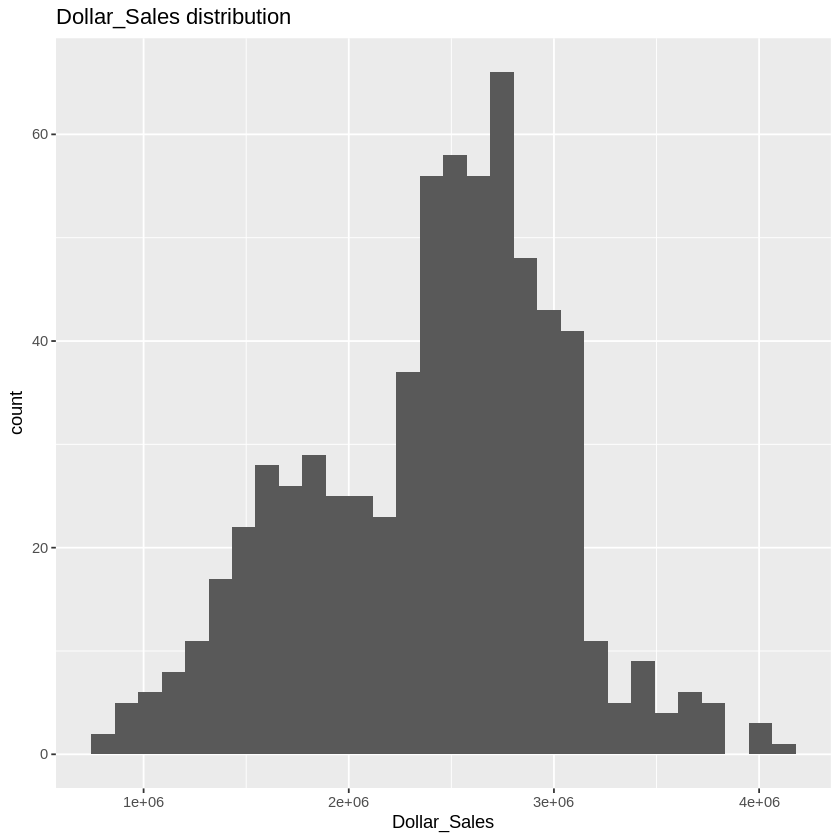

In [ ]:
# Distribución de ventas
ggplot(dat, aes(x = Dollar_Sales)) +
  geom_histogram() +
  labs(title = "Dollar_Sales distribution")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


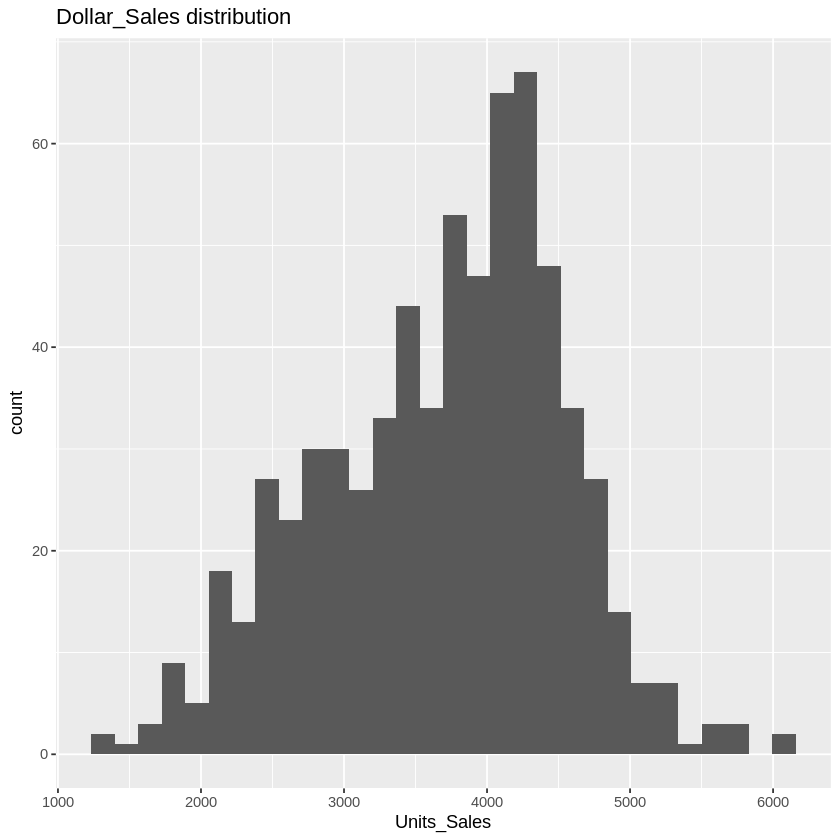

In [ ]:
# Distribución de ventas
ggplot(dat, aes(x = Units_Sales)) +
  geom_histogram() +
  labs(title = "Dollar_Sales distribution")

Warning message:
“Removed 354 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


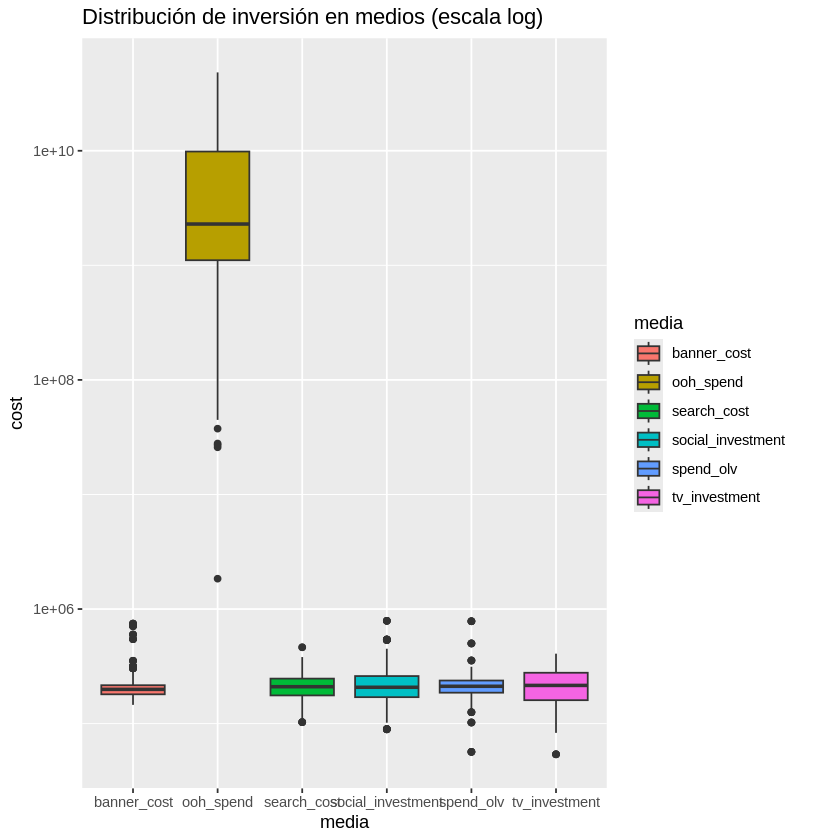

In [ ]:
# Gasto en medios principales
media_cost <- c("banner_cost","spend_olv","social_investment",
                "search_cost","ooh_spend","tv_investment")

ggplot(
  dat %>% tidyr::pivot_longer(
    cols = all_of(media_cost),
    names_to = "media",
    values_to = "cost"
  ),
  aes(x = media, y = cost, fill = media)
) +
  geom_boxplot() +
  scale_y_log10() +
  labs(title = "Distribución de inversión en medios (escala log)")

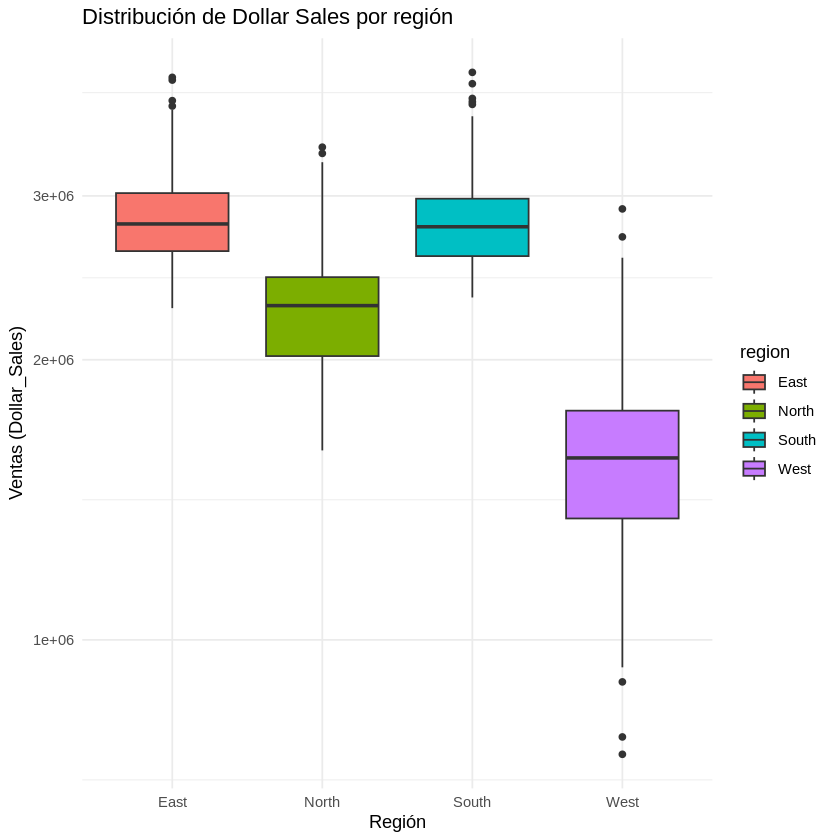

In [ ]:
ggplot(dat, aes(x = region, y = Dollar_Sales, fill = region)) +
  geom_boxplot() +
  scale_y_log10() +  # útil si hay outliers grandes
  labs(title = "Distribución de Dollar Sales por región",
       x = "Región",
       y = "Ventas (Dollar_Sales)") +
  theme_minimal()


In [ ]:
dat %>%
  group_by(region) %>%
  summarise(n(),
    mean  = mean(Dollar_Sales, na.rm = TRUE),
    sd    = sd(Dollar_Sales, na.rm = TRUE),
    median= median(Dollar_Sales, na.rm = TRUE),
    min   = min(Dollar_Sales, na.rm = TRUE),
    max   = max(Dollar_Sales, na.rm = TRUE)
  )

region,n(),mean,sd,median,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
East,169,2844720,334592.0,2798926,2272461.2,4022988
North,169,2268059,341937.8,2286730,1598248.3,3384603
South,182,2817113,333028.9,2779480,2333507.7,4072890
West,156,1587662,366484.8,1568609,753339.8,2905029


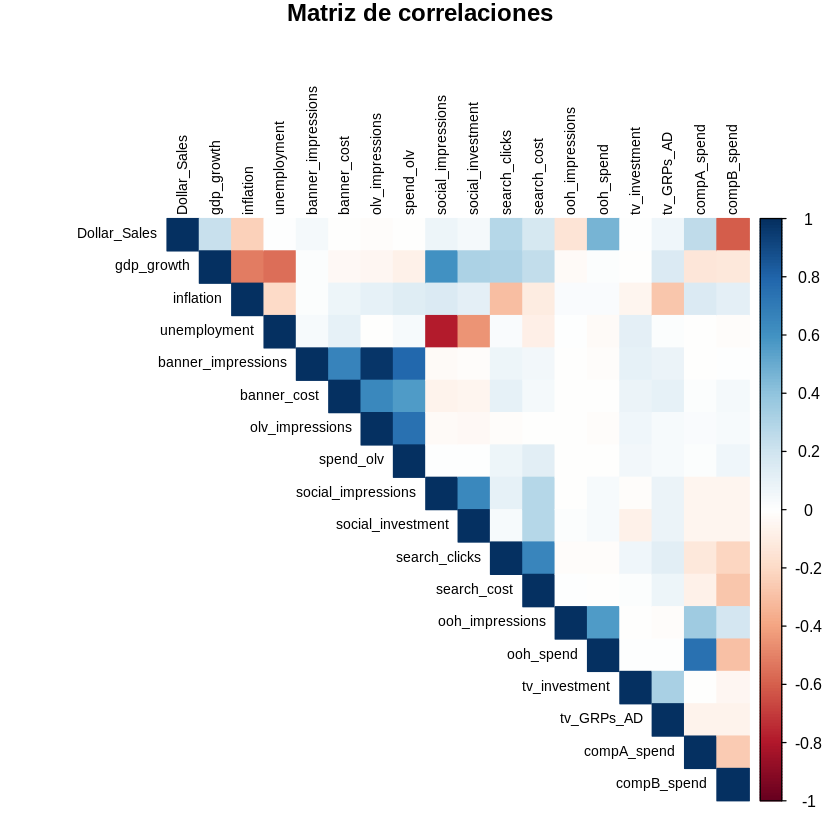

In [ ]:
# corr matrix
num_vars <- dat %>%
  dplyr::select(where(is.numeric)) %>%
  dplyr::select(-any_of("Units_Sales"))

cor_mat <- cor(num_vars, use = "pairwise.complete.obs")

corrplot(cor_mat, method = "color", type = "upper",
         tl.cex = 0.7, tl.col = "black",
         title = "Matriz de correlaciones", mar=c(0,0,1,0))

In [ ]:
cor_mat

,Dollar_Sales,gdp_growth,inflation,unemployment,banner_impressions,banner_cost,olv_impressions,spend_olv,social_impressions,social_investment,search_clicks,search_cost,ooh_impressions,ooh_spend,tv_investment,tv_GRPs_AD,compA_spend,compB_spend
Dollar_Sales,1.000000000,0.225686186,-0.23301411,0.0098922242,0.040394793,-0.007534049,-0.0119178087,-0.004552325,0.074635935,0.049009005,0.28145965,0.172476604,-0.1452766835,0.465735848,0.004776962,0.065260736,0.252570026,-0.60273664
gdp_growth,0.225686186,1.000000000,-0.51356315,-0.5557894389,0.015182390,-0.039342897,-0.0477362971,-0.079170540,0.602074593,0.318470704,0.30900994,0.241505335,-0.0241310823,0.011489296,-0.009470209,0.153709345,-0.135644894,-0.12334072
inflation,-0.233014110,-0.513563147,1.00000000,-0.1917337958,0.016751029,0.077859313,0.1004337710,0.134770163,0.151149086,0.115486078,-0.30010224,-0.109229408,0.0226944561,0.023443766,-0.058054697,-0.278090577,0.152526746,0.11437256
unemployment,0.009892224,-0.555789439,-0.19173380,1.0000000000,0.030129812,0.100632361,-0.0001692566,0.039449894,-0.783963676,-0.446374209,0.02086393,-0.087034739,0.0008879576,-0.026677729,0.111230661,0.017105838,-0.009310924,-0.01586429
banner_impressions,0.040394793,0.015182390,0.01675103,0.0301298118,1.000000000,0.668315883,0.9782990503,0.784849060,-0.022565229,-0.017696644,0.07752697,0.050022050,-0.0081005702,-0.011169436,0.104940060,0.083491400,-0.006585589,0.00778719
banner_cost,-0.007534049,-0.039342897,0.07785931,0.1006323607,0.668315883,1.000000000,0.6472361035,0.564033273,-0.061447423,-0.050790599,0.10895999,0.041709286,-0.0082826843,-0.006212420,0.083166168,0.108171882,0.011848158,0.04600759
olv_impressions,-0.011917809,-0.047736297,0.10043377,-0.0001692566,0.978299050,0.647236103,1.0000000000,0.744790580,-0.029743006,-0.037996179,-0.01276498,-0.005965628,-0.0081955078,-0.011746686,0.066547047,0.030282725,0.021431047,0.03419564
spend_olv,-0.004552325,-0.079170540,0.13477016,0.0394498943,0.784849060,0.564033273,0.7447905803,1.000000000,0.005231816,0.007495681,0.07850385,0.121592905,-0.0037111815,-0.009821170,0.055327774,0.030359577,0.014586712,0.06121569
social_impressions,0.074635935,0.602074593,0.15114909,-0.7839636756,-0.022565229,-0.061447423,-0.0297430065,0.005231816,1.000000000,0.645995126,0.10513629,0.287465840,-0.0056822551,0.032359920,-0.010487910,0.084420987,-0.050194394,-0.05735203
social_investment,0.049009005,0.318470704,0.11548608,-0.4463742094,-0.017696644,-0.050790599,-0.0379961788,0.007495681,0.645995126,1.000000000,0.03270400,0.283373246,0.0113524384,0.035470278,-0.072671291,0.080207746,-0.059870339,-0.05359326


In [ ]:
colnames(dat)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"

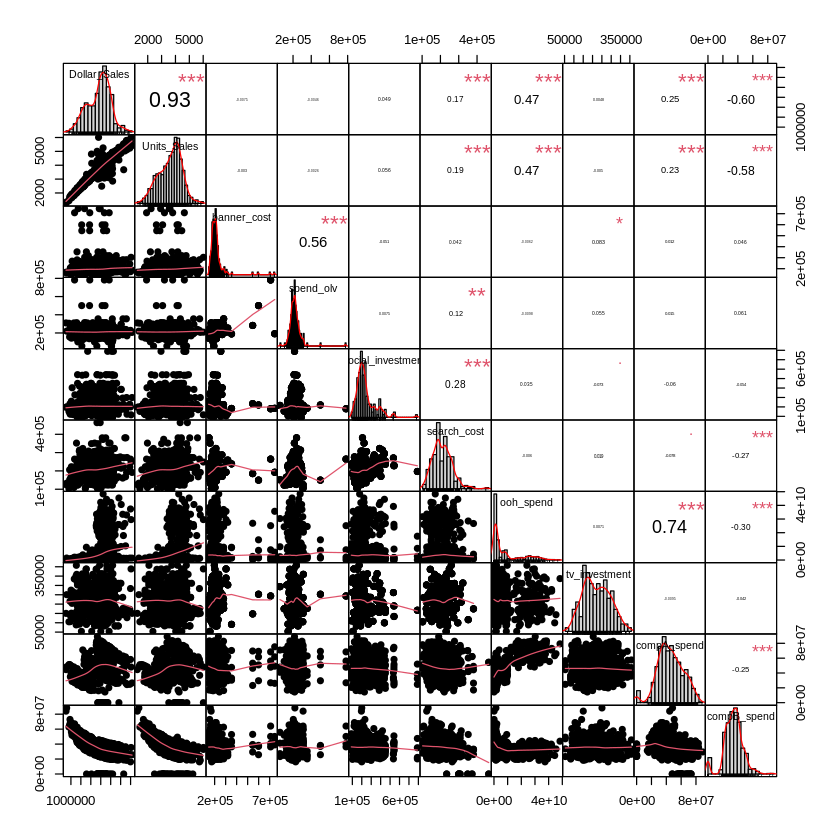

In [ ]:
cost_vars <- c('Dollar_Sales','Units_Sales','banner_cost','spend_olv','social_investment','search_cost',
               'ooh_spend','tv_investment', 'compA_spend','compB_spend')
cost_dat <- dat[, cost_vars]
chart.Correlation(cost_dat, histogram = TRUE, pch=19)

In [ ]:
colnames(dat)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"

[1] "Dollar_Sales"       "banner_impressions" "olv_impressions"   
[4] "social_impressions" "search_clicks"      "ooh_impressions"   
[7] "tv_GRPs_AD"

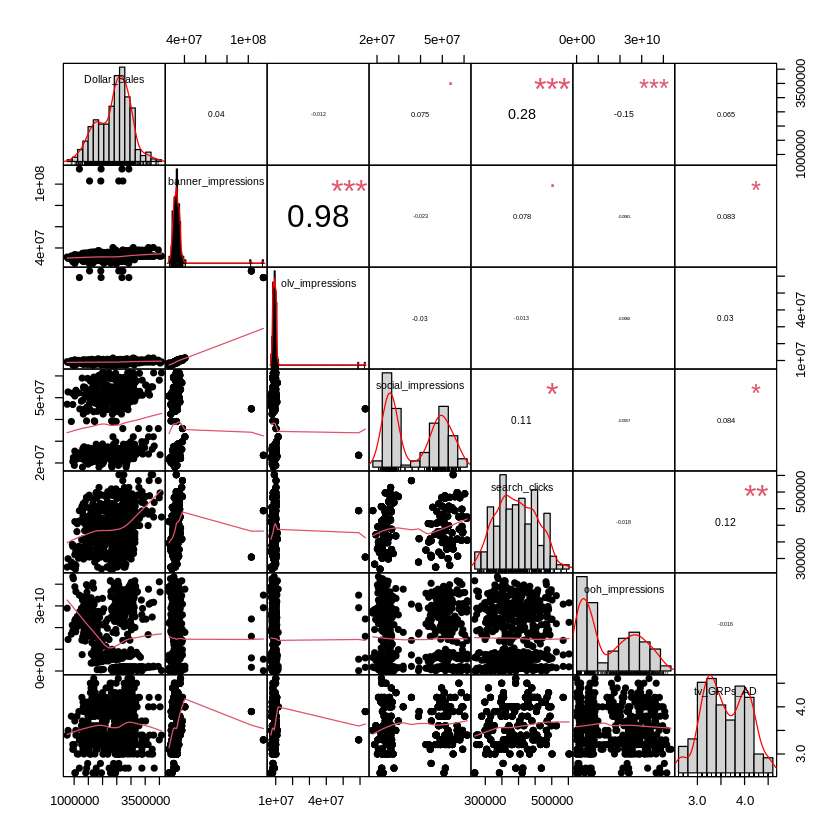

In [ ]:
interaction_vars <- c('Dollar_Sales','banner_impressions','olv_impressions','social_impressions', 'search_clicks',
                      'ooh_impressions','tv_GRPs_AD')
interaction_dat <- dat[, interaction_vars]
interaction_vars
# str(interaction_dat)
chart.Correlation(interaction_dat, histogram = TRUE, pch=19)

In [ ]:
# missing values
print(colSums(is.na(dat)))

# no records -> no media activity that week

media_vars <- c("banner_impressions", "banner_cost",
                "olv_impressions", "spend_olv",
                "social_impressions", "social_investment",
                "search_clicks", "search_cost",
                "ooh_impressions", "ooh_spend",
                "tv_investment", "tv_GRPs_AD",
                "compA_spend", "compB_spend")
macro_vars <- c("gdp_growth","inflation","unemployment")
ctrl_vars  <- c("compA_spend","compB_spend")
y_var <- "Dollar_Sales"

dat[media_vars] <- lapply(dat[media_vars],
                           function(x) replace(x, is.na(x), 0))

sapply(dat[media_vars], function(x) sum(is.na(x)))

na_weeks <- unique(dat$week_start[is.na(dat$gdp_growth)])
na_weeks

dat1 <- dat[!format(dat$week_start, "%Y") %in% c("2019","2023"), ]

        week_start             region       Dollar_Sales        Units_Sales 
                 0                  0                  0                  0 
        gdp_growth          inflation       unemployment banner_impressions 
                52                 52                 52                 52 
       banner_cost    olv_impressions          spend_olv social_impressions 
                52                 52                 52                 52 
 social_investment      search_clicks        search_cost    ooh_impressions 
                52                 66                 66                 52 
         ooh_spend      tv_investment         tv_GRPs_AD        compA_spend 
                52                 80                 80                 10 
       compB_spend 
                 5 


banner_impressions        banner_cost    olv_impressions          spend_olv 
                 0                  0                  0                  0 
social_impressions  social_investment      search_clicks        search_cost 
                 0                  0                  0                  0 
   ooh_impressions          ooh_spend      tv_investment         tv_GRPs_AD 
                 0                  0                  0                  0 
       compA_spend        compB_spend 
                 0                  0

[1] "2023-01-01" "2023-01-08" "2023-01-15" "2023-01-22" "2023-01-29"
 [6] "2023-02-05" "2023-02-12" "2023-02-19" "2023-02-26" "2023-03-05"
[11] "2023-03-12" "2023-03-19" "2023-03-26" "2019-10-06" "2019-10-13"
[16] "2019-10-20" "2019-10-27" "2019-11-03" "2019-11-10" "2019-11-17"
[21] "2019-11-24" "2019-12-01" "2019-12-08" "2019-12-15" "2019-12-22"
[26] "2019-12-29"

In [ ]:
# outliers
numeric_vars <- dat1[, sapply(dat1, is.numeric)]

outlier_indices <- lapply(numeric_vars, outliers_iqr)

outlier_summary <- data.frame(
  variable = names(outlier_indices),
  n_outliers = sapply(outlier_indices, length),
  perc_outliers = round(100 * sapply(outlier_indices, length) / nrow(dat), 2)
)

print(outlier_summary)

                             variable n_outliers perc_outliers
Dollar_Sales             Dollar_Sales          0          0.00
Units_Sales               Units_Sales          0          0.00
gdp_growth                 gdp_growth         20          2.96
inflation                   inflation          0          0.00
unemployment             unemployment          0          0.00
banner_impressions banner_impressions         12          1.78
banner_cost               banner_cost         48          7.10
olv_impressions       olv_impressions          8          1.18
spend_olv                   spend_olv         20          2.96
social_impressions social_impressions          0          0.00
social_investment   social_investment         48          7.10
search_clicks           search_clicks         28          4.14
search_cost               search_cost         36          5.33
ooh_impressions       ooh_impressions          0          0.00
ooh_spend                   ooh_spend        108       

In [ ]:
vars_outliers <- c("gdp_growth", "banner_impressions", "banner_cost",
                   "olv_impressions", "spend_olv", "social_investment",
                   "search_clicks", "search_cost", "ooh_spend", "tv_GRPs_AD",
                   "compB_spend")

dat1_imput <- dat1 %>%
  mutate(across(all_of(vars_outliers), imput_iqr))

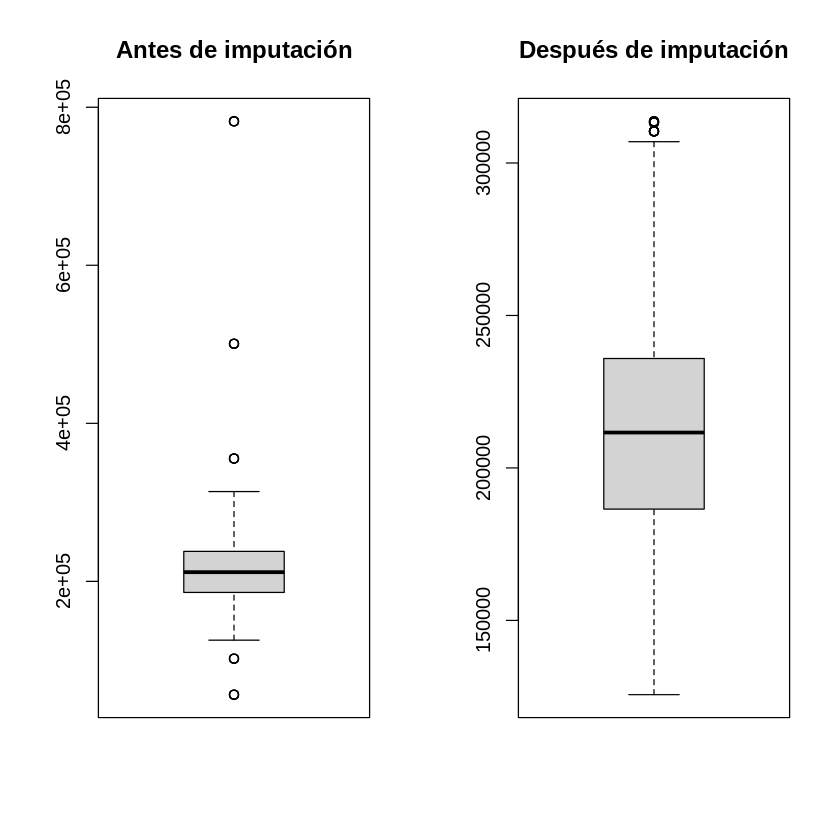

In [ ]:
par(mfrow=c(1,2))
boxplot(dat1$spend_olv, main = "Antes de imputación")
boxplot(dat1_imput$spend, main = "Después de imputación")


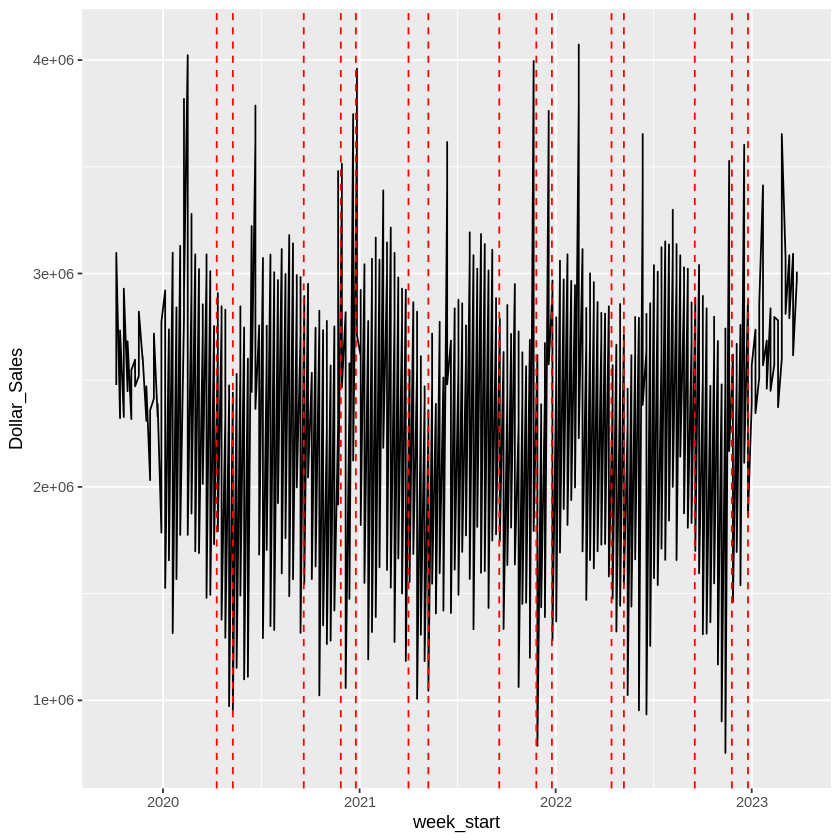

In [ ]:
# feature engineering

# special dates analysis 2020-2022
special_dates <- as.Date(c("2020-05-10", "2021-05-09", "2022-05-08", # mother's day
                           "2020-09-19", "2021-09-18", "2022-09-17",   # valentine's day
                           "2020-11-27", "2021-11-26", "2022-11-25", # black friday
                           "2020-12-25", "2021-12-25", "2022-12-25",   # christmas
                           "2020-04-10", "2021-04-02", "2022-04-15"))   # holy week

ggplot(dat, aes(week_start, Dollar_Sales)) +
  geom_line() +
  geom_vline(xintercept = as.numeric(special_dates), linetype = "dashed", color = "red")

In [ ]:
dat_features <- dat1_imput %>%
  dplyr::mutate(
    week_start = as.Date(week_start),
    region     = as.factor(region),
    is_special_week = if_else(week_start %in% special_dates, 1, 0),
  ) %>%
  dplyr::arrange(week_start, region) %>%
  dplyr::mutate(
    trend   = dplyr::row_number(),
    quarter = base::factor(lubridate::quarter(week_start)),
    total_spend = base::rowSums(
      cbind(banner_cost, spend_olv, social_investment, search_cost, ooh_spend, tv_investment),
      na.rm = TRUE
    ),
    CPM_banner = safe_div(banner_cost * 1000, banner_impressions),
    CPM_olv    = safe_div(spend_olv    * 1000, olv_impressions),
    CPC_search = safe_div(search_cost,          search_clicks),
    share_banner = safe_div(banner_cost,       total_spend),
    share_olv    = safe_div(spend_olv,         total_spend),
    share_social = safe_div(social_investment, total_spend),
    share_search = safe_div(search_cost,       total_spend),
    share_ooh    = safe_div(ooh_spend,         total_spend),
    share_tv     = safe_div(tv_investment,     total_spend)
  ) %>%
  dplyr::group_by(region) %>%
  dplyr::mutate(
    banner_cost_lag1 = dplyr::lag(banner_cost, 1),
    spend_olv_lag1   = dplyr::lag(spend_olv, 1),
    social_inv_lag1  = dplyr::lag(social_investment, 1),
    search_cost_lag1 = dplyr::lag(search_cost, 1),
    tv_invest_lag1   = dplyr::lag(tv_investment, 1)
  ) %>%
  dplyr::ungroup() %>%
  dplyr::mutate(
    ROI_proxy = safe_div(Dollar_Sales, total_spend)
  )  %>%
  tidyr::drop_na()

In [ ]:
head(dat_features)

week_start,region,Dollar_Sales,Units_Sales,gdp_growth,inflation,unemployment,banner_impressions,banner_cost,olv_impressions,⋯,share_social,share_search,share_ooh,share_tv,banner_cost_lag1,spend_olv_lag1,social_inv_lag1,search_cost_lag1,tv_invest_lag1,ROI_proxy
<date>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-12,East,2738600,3927,3.11,2.77,7.77,28992557,171153.2,7940685,⋯,4.613917e-05,1.042651e-04,0.9995921,9.926651e-05,157376.1,146025.2,106936.6,231308.3,53935.92,0.0010331429
2020-01-12,North,2536311,4106,3.11,2.77,7.77,28992557,171153.2,7940685,⋯,5.240548e-05,1.184257e-04,0.9995366,1.127482e-04,157376.1,146025.2,106936.6,231308.3,53935.92,0.0010867791
2020-01-12,South,2553894,3644,3.11,2.77,7.77,28992557,171153.2,7940685,⋯,1.301350e-05,2.940787e-05,0.9998849,2.799801e-05,157376.1,146025.2,106936.6,231308.3,53935.92,0.0002717434
2020-01-12,West,1656332,2503,3.11,2.77,7.77,28992557,171153.2,7940685,⋯,1.189673e-04,2.688419e-04,0.9989481,2.559532e-04,157376.1,146025.2,106936.6,231308.3,53935.92,0.0016111537
2020-01-19,East,3097300,4358,3.11,2.77,7.77,34970672,189219.4,10385878,⋯,7.451873e-06,1.936608e-05,0.9999065,2.666060e-05,171153.2,248397.5,122303.2,276380.4,263130.32,0.0002590616
2020-01-19,North,2566149,4209,3.11,2.77,7.77,34970672,189219.4,10385878,⋯,4.830205e-05,1.255284e-04,0.9993938,1.728105e-04,171153.2,248397.5,122303.2,276380.4,263130.32,0.0013912388


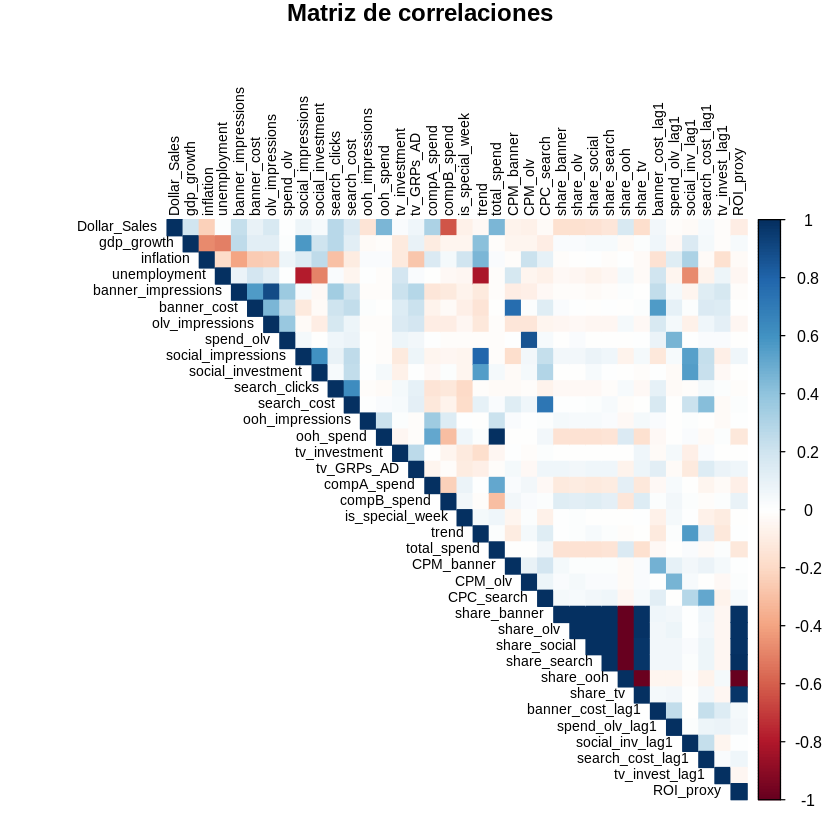

In [ ]:
# corr matrix
num_vars <- dat_features %>%
  dplyr::select(where(is.numeric), -Units_Sales)

cor_mat <- cor(num_vars, use = "pairwise.complete.obs")

corrplot(cor_mat, method = "color", type = "upper",
         tl.cex = 0.7, tl.col = "black",
         title = "Matriz de correlaciones", mar=c(0,0,1,0))

In [ ]:
# train - test split

# copy data
dat_model <- dat_features

dates <- sort(unique(dat_model$week_start))
cut_date <- dates[floor(0.8 * length(dates))]

train_data <- dat_model %>% filter(week_start <= cut_date)
test_data  <- dat_model %>% filter(week_start > cut_date)

range(train_data$week_start)
range(test_data$week_start)
nrow(train_data)
nrow(test_data)

[1] "2020-01-12" "2022-05-22"

[1] "2022-05-29" "2022-12-25"

[1] 496

[1] 124

In [ ]:
colnames(train_data)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"       
[22] "is_special_week"    "trend"              "quarter"           
[25] "total_spend"        "CPM_banner"         "CPM_olv"           
[28] "CPC_search"         "share_banner"       "share_olv"         
[31] "share_social"       "share_search"       "share_ooh"         
[34] "share_tv"           "banner_cost_lag1"   "spend_olv_lag1"    
[37] "social_inv_lag1"    "search_cost_lag1"   "tv_invest_lag1"    
[40] "ROI_proxy"

In [ ]:
to_scale <- c("Units_Sales", "gdp_growth", "inflation", "unemployment", "banner_impressions", "banner_cost",
              "olv_impressions", "spend_olv", "social_impressions", "social_investment", "search_clicks",
              "search_cost", "ooh_impressions", "ooh_spend", "tv_investment", "tv_GRPs_AD", "compA_spend",
              "compB_spend", "trend", "total_spend", "CPM_banner", "CPM_olv", "CPC_search", "share_banner",
               "share_olv", "share_social", "share_search", "share_ooh", "share_tv", "banner_cost_lag1",
               "spend_olv_lag1", "social_inv_lag1", "search_cost_lag1",  "tv_invest_lag1", "ROI_proxy")

In [ ]:
mu  <- sapply(train_data[to_scale], mean, na.rm = TRUE)
sdv <- sapply(train_data[to_scale],  sd,  na.rm = TRUE)

# scale
train_data <- scale_with(train_data, to_scale, mu, sdv)
test_data  <- scale_with(test_data,  to_scale, mu, sdv)

# dummies
train_data$region <- relevel(as.factor(train_data$region), ref = "West")
test_data$region  <- relevel(as.factor(test_data$region),  ref = "West")
train_data <- cbind(train_data, as.data.frame(model.matrix(~ region, data = train_data)[, -1]))
test_data  <- cbind(test_data,  as.data.frame(model.matrix(~ region, data = test_data)[ , -1]))

train_data$quarter <- as.factor(train_data$quarter)
test_data$quarter  <- as.factor(test_data$quarter)

train_data$is_special_week <- as.factor(train_data$is_special_week)
test_data$is_special_week  <- as.factor(test_data$is_special_week)

In [ ]:
# full model: variables not even slightly correlated with Dollar Sales or built with it are skipped: Unemployment, TV Investment,
# tv_GRPs_AD, banner_impressions, banner_cost, olv_impressions, spend_olv, social_investment

drop_cols <- c("Dollar_Sales", "Units_Sales", "week_start", "region", "total_spend", "unemployment",
               "ROI_proxy", "is_peak_high", "is_peak_low", "total_spend", "CPM_banner", "CPM_olv", "CPC_search",
               "share_banner", "share_olv", "share_social", "share_search", "share_ooh", "share_tv")
x_cols <- setdiff(names(train_data), drop_cols)
form  <- as.formula(paste("Dollar_Sales ~", paste(x_cols, collapse = " + ")))

# full
mod_full <- lm(form, data = train_data)
summary(mod_full)
# predictions
pred_train <- predict(mod_full, newdata = train_data[, c(x_cols, "Dollar_Sales")])
pred_test  <- predict(mod_full, newdata = test_data[, c(x_cols, "Dollar_Sales")])
# metrics
metrics_train <- metrics(train_data$Dollar_Sales, pred_train)
metrics_test  <- metrics(test_data$Dollar_Sales, pred_test)

metrics_train
metrics_test

# vif's
vif_vals <- car::vif(mod_full)
sort(vif_vals, decreasing = TRUE)


Call:
lm(formula = form, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-700590 -130273  -13376  122318  761549 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1441981      41842  34.462  < 2e-16 ***
gdp_growth            12395      21325   0.581 0.561350    
inflation            -63411      23655  -2.681 0.007608 ** 
banner_impressions    99934      29921   3.340 0.000905 ***
banner_cost          -23274      15118  -1.540 0.124349    
olv_impressions      -17141      25124  -0.682 0.495411    
spend_olv            -35632      13710  -2.599 0.009648 ** 
social_impressions    16392      25078   0.654 0.513674    
social_investment     18493      15258   1.212 0.226106    
search_clicks         81025      16145   5.019 7.42e-07 ***
search_cost          -18099      16120  -1.123 0.262118    
ooh_impressions      -63457      27080  -2.343 0.019532 *  
ooh_spend            -14355      14105  -1.018 0.309330    
tv_inv

RMSE         MAPE           R2 
2.176559e+05 7.503558e-02 8.769327e-01

RMSE         MAPE           R2 
2.204581e+05 7.860130e-02 8.790857e-01

[1] 8.835298 8.788387 7.330624 7.198726 6.266474 6.196602 6.174067 5.493097
 [9] 4.879287 4.552278 4.464262 3.547019 3.000000 2.972423 2.964521 2.707512
[17] 2.683044 2.558901 2.550946 2.503293 2.489297 2.484767 2.343736 2.332296
[25] 2.285357 2.243516 2.208911 2.133607 2.112880 1.952947 1.845245 1.721428
[33] 1.659176 1.640334 1.599657 1.597168 1.594030 1.527186 1.511740 1.497837
[41] 1.423031 1.397479 1.365099 1.358398 1.312032 1.288090 1.282525 1.280755
[49] 1.262549 1.238572 1.234935 1.192908 1.168375 1.132486 1.112912 1.000000
[57] 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
[65] 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
[73] 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
[81] 1.000000

In [ ]:
colnames(train_data)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"       
[22] "is_special_week"    "trend"              "quarter"           
[25] "total_spend"        "CPM_banner"         "CPM_olv"           
[28] "CPC_search"         "share_banner"       "share_olv"         
[31] "share_social"       "share_search"       "share_ooh"         
[34] "share_tv"           "banner_cost_lag1"   "spend_olv_lag1"    
[37] "social_inv_lag1"    "search_cost_lag1"   "tv_invest_lag1"    
[40] "ROI_proxy"          "regionEast"         "regionNorth"       
[43] "regionSouth"

In [ ]:
drop_cols <- c("Dollar_Sales", "Units_Sales", "week_start", "region", "total_spend", "unemployment",
               "ROI_proxy", "is_peak_high", "is_peak_low", "total_spend", "CPM_banner", "CPM_olv", "CPC_search",
               "share_banner", "share_olv", "share_social", "share_search", "share_ooh", "share_tv",
               # no significantes
               'gdp_growth','banner_cost', 'olv_impressions','social_impressions','social_investment',
               'search_cost','tv_investment','tv_GRPs_AD', 'ooh_spend','is_special_week','quarter', 'banner_cost_lag1',
               'social_inv_lag1','search_cost_lag1')
x_cols <- setdiff(names(train_data), drop_cols)
form  <- as.formula(paste("Dollar_Sales ~", paste(x_cols, collapse = " + ")))

# mod 1: dropped non significant variables
mod1 <- lm(form, data = train_data)
summary(mod1)
# predictions
pred_train <- predict(mod1, newdata = train_data[, c(x_cols, "Dollar_Sales")])
pred_test  <- predict(mod1, newdata = test_data[, c(x_cols, "Dollar_Sales")])
# metrics
metrics_train <- metrics(train_data$Dollar_Sales, pred_train)
metrics_test  <- metrics(test_data$Dollar_Sales, pred_test)

metrics_train
metrics_test

# vif's
vif_vals <- car::vif(mod1)
sort(vif_vals, decreasing = TRUE)


Call:
lm(formula = form, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-686252 -138624  -16674  126808  756180 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1448638      35227  41.123  < 2e-16 ***
inflation            -78108      13367  -5.843 9.43e-09 ***
banner_impressions    64727      12805   5.055 6.13e-07 ***
spend_olv            -35706      12325  -2.897  0.00394 ** 
search_clicks         73230      11495   6.371 4.40e-10 ***
ooh_impressions      -60263      26709  -2.256  0.02450 *  
compA_spend         -263585      21081 -12.503  < 2e-16 ***
compB_spend          -90658      12822  -7.071 5.45e-12 ***
trend                 23464      11935   1.966  0.04987 *  
spend_olv_lag1        45457      11508   3.950 8.98e-05 ***
tv_invest_lag1       -42126      10528  -4.001 7.29e-05 ***
regionEast          1781993      63193  28.199  < 2e-16 ***
regionNorth          790912      50800  15.569  < 2e-16 ***
region

RMSE         MAPE           R2 
2.211011e+05 7.618729e-02 8.730058e-01

RMSE         MAPE           R2 
2.268399e+05 8.461117e-02 8.719840e-01

regionEast    ooh_impressions        regionSouth        regionNorth 
          7.382563           7.019658           6.032026           4.770878 
       compA_spend          inflation        compB_spend banner_impressions 
          4.372947           1.758196           1.617610           1.613391 
         spend_olv              trend     spend_olv_lag1      search_clicks 
          1.494734           1.401614           1.303113           1.300222 
    tv_invest_lag1 
          1.090613

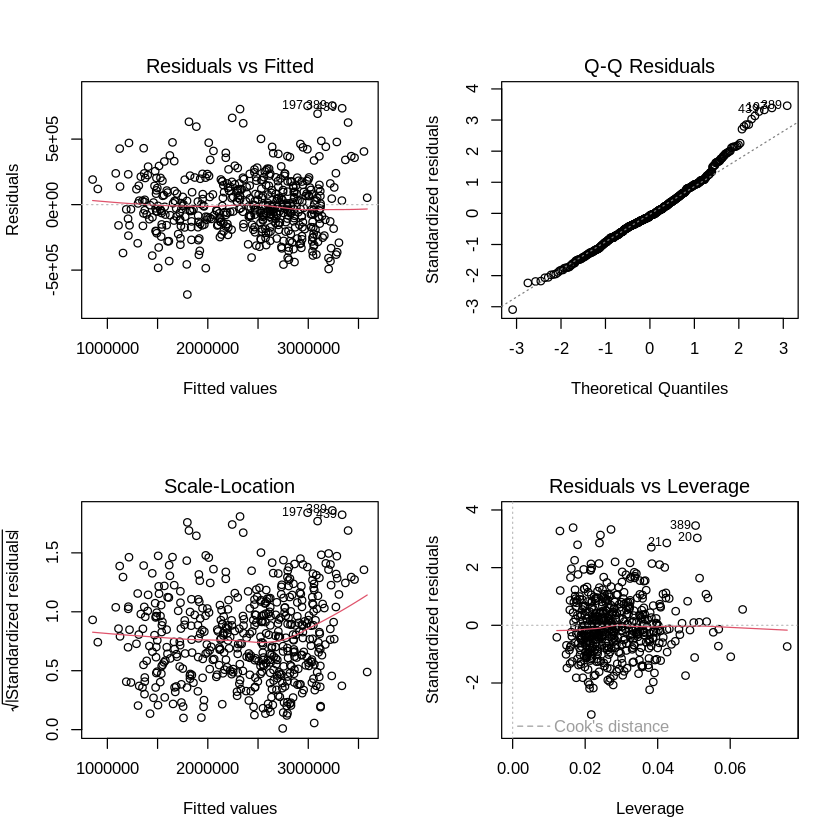

In [ ]:
par(mfrow = c(2, 2))
plot(mod1)              # 4 plots clásicos de diagnóstico
par(mfrow = c(1, 1))


In [ ]:
library(lmtest); library(sandwich)
dwtest(mod1)                               # autocorrelación
bptest(mod1)                                # heterocedasticidad
coeftest(mod1, vcov = NeweyWest(mod, lag = 2))  # SE robustos (reporta estos)


	Durbin-Watson test

data:  mod1
DW = 1.4163, p-value = 9.426e-12
alternative hypothesis: true autocorrelation is greater than 0



	studentized Breusch-Pagan test

data:  mod1
BP = 50.389, df = 13, p-value = 2.557e-06



t test of coefficients:

                   Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)         1448638      33298  43.5060 < 2.2e-16 ***
banner_impressions    64727      12638   5.1217 4.385e-07 ***
spend_olv            -35706      12448  -2.8685  0.004306 ** 
search_clicks         73230      14857   4.9290 1.139e-06 ***
compA_spend         -263585      25689 -10.2608 < 2.2e-16 ***
compB_spend          -90658      15131  -5.9915 4.074e-09 ***
trend                 23464      27192   0.8629  0.388614    
tv_invest_lag1       -42126      14265  -2.9531  0.003300 ** 
regionEast          1781993      64166  27.7716 < 2.2e-16 ***
regionNorth          790912      37441  21.1241 < 2.2e-16 ***
regionSouth         1161455      37596  30.8933 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


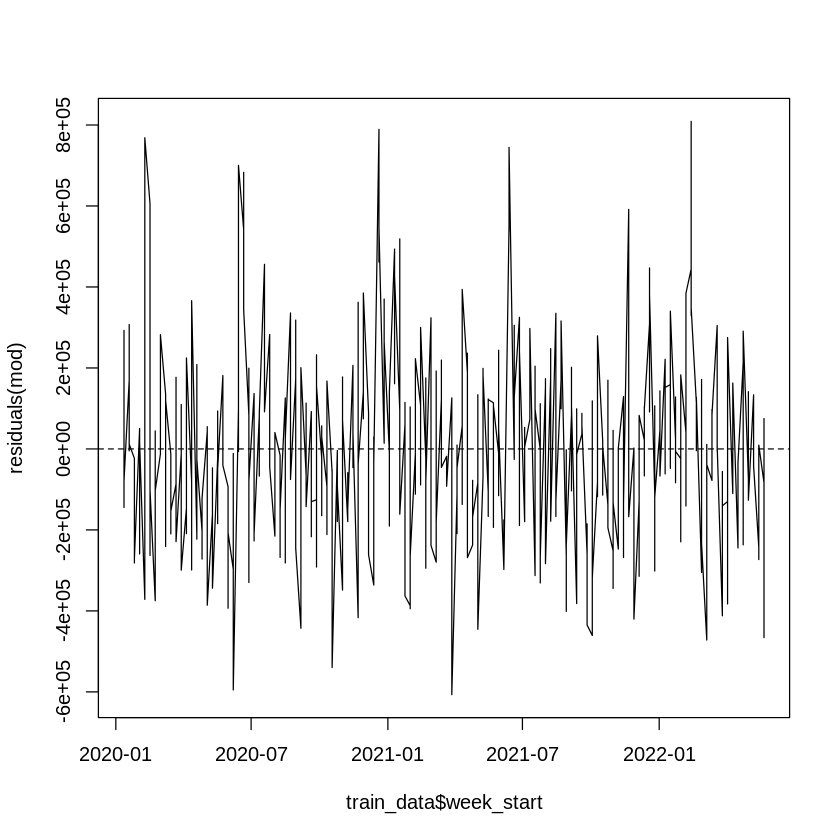

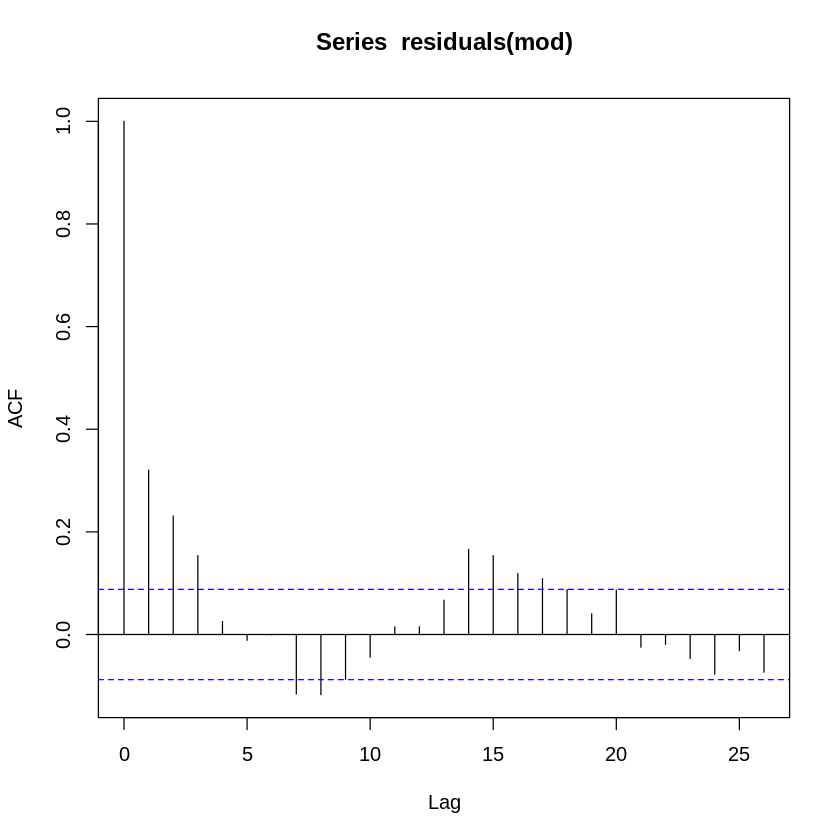

In [ ]:
plot(train_data$week_start, residuals(mod), type="l"); abline(h=0,lty=2)
acf(residuals(mod))


In [ ]:
form

Dollar_Sales ~ inflation + banner_impressions + spend_olv + search_clicks + 
    ooh_impressions + compA_spend + compB_spend + trend + spend_olv_lag1 + 
    tv_invest_lag1 + regionEast + regionNorth + regionSouth

In [ ]:
# gls
gls_mod <- gls(
  form,
  data = train_data,
  correlation = corAR1(form = ~ 1 | region),  # AR(1) por region
  method = "REML"
)

summary(gls_mod)
# predictions
pred_train_gls <- predict(gls_mod, newdata = train_data)
pred_test_gls  <- predict(gls_mod, newdata = test_data)
#metrics
metrics_train_gls <- metrics(train_data$Dollar_Sales, pred_train_gls)
metrics_test_gls  <- metrics(test_data$Dollar_Sales, pred_test_gls)

metrics_train_gls
metrics_test_gls

Generalized least squares fit by REML
  Model: form 
  Data: train_data 
       AIC      BIC   logLik
  13353.18 13420.03 -6660.59

Correlation Structure: AR(1)
 Formula: ~1 | region 
 Parameter estimate(s):
        Phi 
-0.01520403 

Coefficients:
                       Value Std.Error   t-value p-value
(Intercept)        1449078.3  35050.71  41.34234  0.0000
inflation           -78362.1  13236.59  -5.92011  0.0000
banner_impressions   64686.1  12779.13   5.06185  0.0000
spend_olv           -35447.5  12300.29  -2.88184  0.0041
search_clicks        73206.4  11488.10   6.37237  0.0000
ooh_impressions     -61252.2  26704.05  -2.29374  0.0222
compA_spend        -263594.1  21103.28 -12.49067  0.0000
compB_spend         -90551.7  12808.02  -7.06992  0.0000
trend                23600.3  11769.40   2.00522  0.0455
spend_olv_lag1       45316.2  11511.24   3.93669  0.0001
tv_invest_lag1      -42436.6  10531.81  -4.02937  0.0001
regionEast         1782801.1  63037.46  28.28161  0.0000
regionNort

RMSE         MAPE           R2 
2.211019e+05 7.618512e-02 8.730050e-01

RMSE         MAPE           R2 
2.268729e+05 8.466665e-02 8.719467e-01

In [ ]:
# Fitted values y residuos
fitted_vals <- fitted(gls_mod)
resid_vals  <- resid(gls_mod)

# Pseudo R² = correlación al cuadrado
pseudo_r2 <- cor(train_data$Dollar_Sales, fitted_vals)^2
pseudo_r2

[1] 0.873005

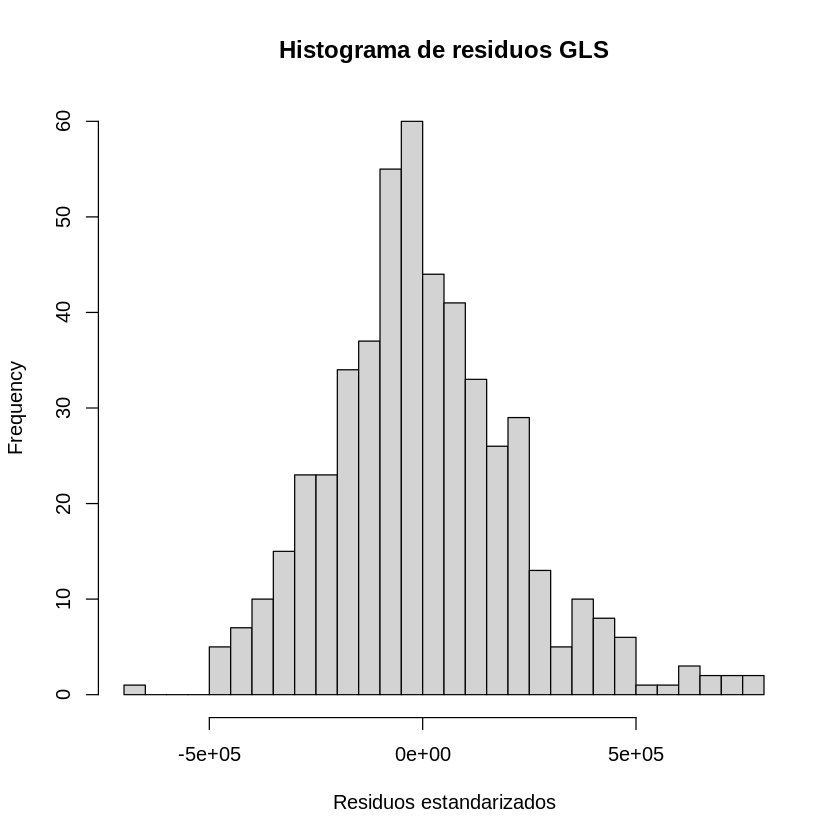

In [ ]:
hist(resid_vals, breaks = 30,
     main = "Histograma de residuos GLS",
     xlab = "Residuos estandarizados")


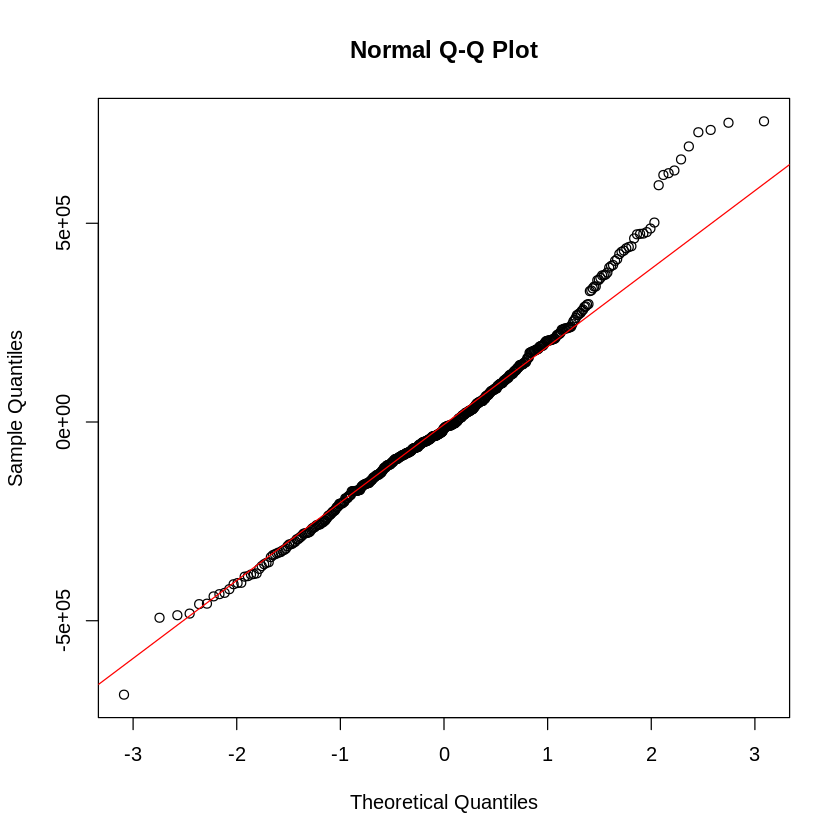

In [ ]:
qqnorm(resid_vals)
qqline(resid_vals, col = "red")

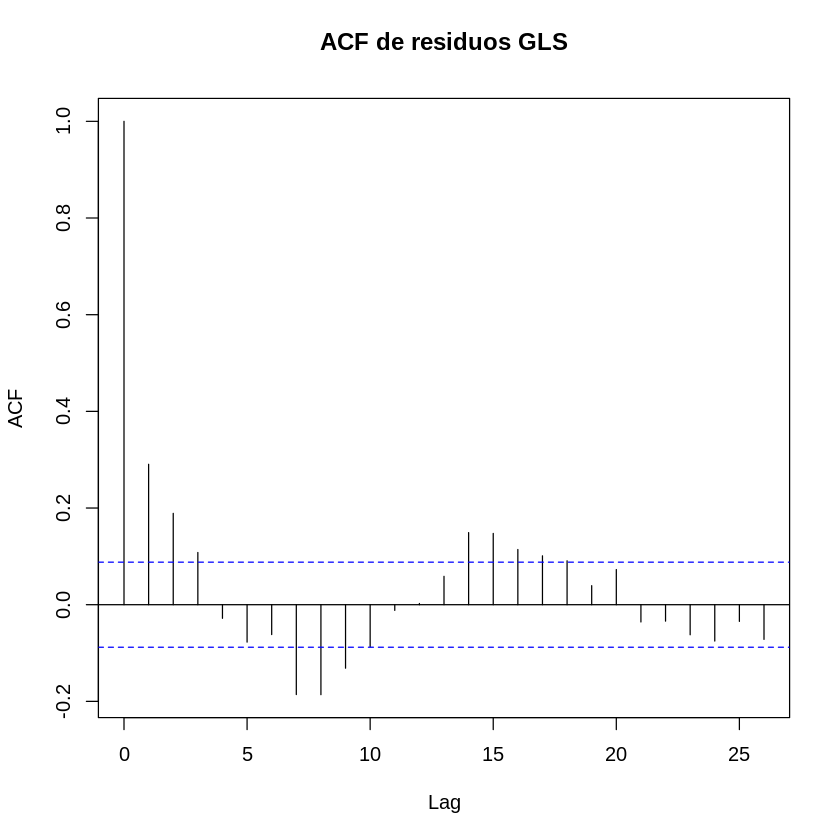

In [ ]:
acf(resid_vals, main = "ACF de residuos GLS")